In [1]:
!pip install bioinfokit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.1/88.1 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for bioinfokit: filename=bioinfokit-2.1.4-py3-none-any.whl size=59221 sha256=d8e782ea6d4253a8b624e848803863247894ffcee576bc858ed46e09e4b14a78
  Stored in directory: /root/.cache/pip/wheels/45/b1/91/212510cab723ee76a25180836e8897f926820382374184b017
Successfully built bioinfokit


In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from bioinfokit.visuz import cluster
from sklearn.utils import resample
from scipy.stats import entropy
from patsy import dmatrices
from statsmodels.graphics.mosaicplot import mosaic

In [3]:
# Load the dataset
data = pd.read_csv("mcdonalds.csv")
MD = data.iloc[:, 0:11].applymap(lambda x: 1 if x == "Yes" else 0)
print(MD.mean().round(2))
scaler = StandardScaler()
MD_scaled = scaler.fit_transform(MD)


yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
dtype: float64


[0.25556637 0.14834762 0.12546909 0.09826971 0.08348356 0.07109102
 0.06498559 0.05384477 0.04762809 0.02796379 0.0233504 ]
[[-0.40695508 -0.30882741 -0.02332033  0.17786071  0.26779582 -0.21303906
  -0.28913434 -0.42611499  0.29094445 -0.26683857  0.41074387]
 [ 0.28261487 -0.04568172  0.0699822  -0.20559024 -0.13630029 -0.28244059
  -0.57503178  0.24219851  0.56752776  0.20103082 -0.14388846]
 [-0.25958798 -0.31715142  0.0201696  -0.60807736 -0.38956798 -0.21139458
   0.1251574  -0.26964779 -0.18329788  0.36781371  0.09029919]
 [ 0.02623694 -0.00942396  0.84549641 -0.02339555  0.33085439  0.09036315
   0.11447698  0.0726908   0.03550987  0.30198954  0.23523093]
 [ 0.34685741 -0.43714795 -0.185551    0.08693385  0.3437128  -0.56893862
   0.25698101  0.2860986  -0.20736179  0.05178742  0.10584327]
 [-0.12491568  0.18896641  0.43866119  0.1075199  -0.27832865 -0.57273434
   0.02065707 -0.05305267 -0.17116009 -0.4461664  -0.32804054]
 [ 0.15987822 -0.66181418  0.21418844 -0.0238514  -0.3

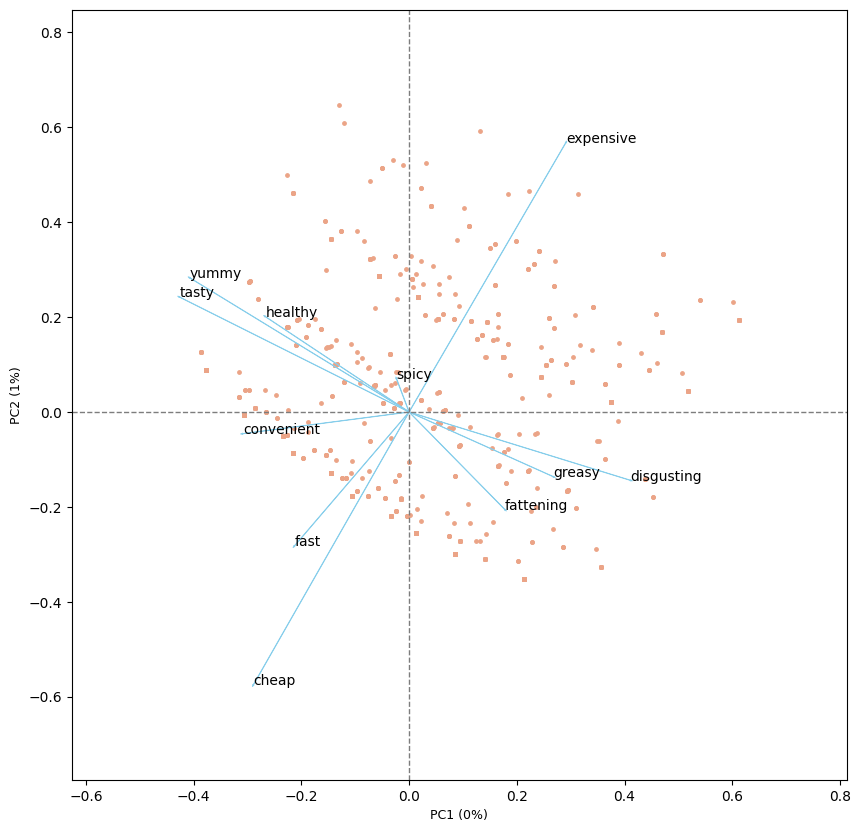

In [4]:
pca = PCA()
MD_pca = pca.fit_transform(MD_scaled)
explained_variance = pca.explained_variance_ratio_
components = pca.components_

print(explained_variance)
print(components)

cluster.biplot(cscore=MD_pca, loadings=components, labels=data.columns.values, var1=0, var2=1, show=True, dim=(10, 10))


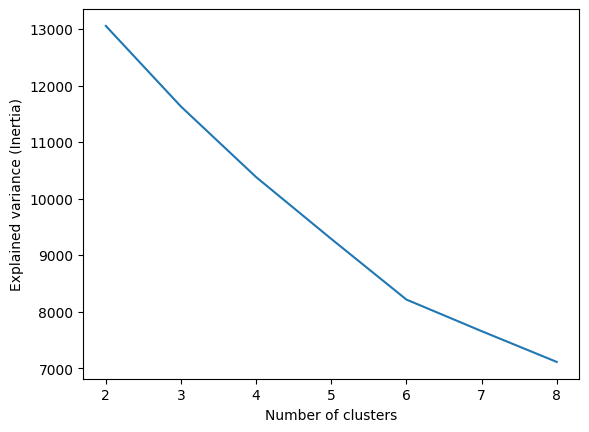

In [5]:
n_clusters = range(2, 9)
kmeans_models = [KMeans(n_clusters=k, n_init=10, random_state=1234).fit(MD_scaled) for k in n_clusters]

plt.plot(n_clusters, [model.inertia_ for model in kmeans_models])
plt.xlabel("Number of clusters")
plt.ylabel("Explained variance (Inertia)")
plt.show()

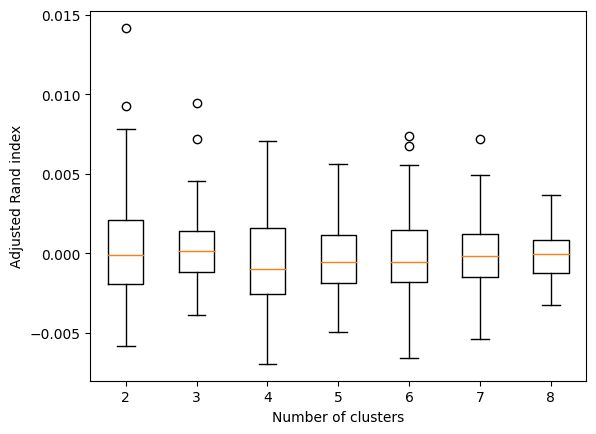

In [6]:
def bootstrap_stability(data, kmeans_model, n_bootstrap=100):
    ari_scores = []
    for _ in range(n_bootstrap):
        sample = resample(data)
        kmeans_sample = KMeans(n_clusters=kmeans_model.n_clusters, n_init=10, random_state=1234).fit(sample)
        ari = adjusted_rand_score(kmeans_model.labels_, kmeans_sample.labels_)
        ari_scores.append(ari)
    return ari_scores

bootstrap_results = {k: bootstrap_stability(MD_scaled, model) for k, model in zip(n_clusters, kmeans_models)}


plt.boxplot(bootstrap_results.values(), labels=n_clusters)
plt.xlabel("Number of clusters")
plt.ylabel("Adjusted Rand index")
plt.show()

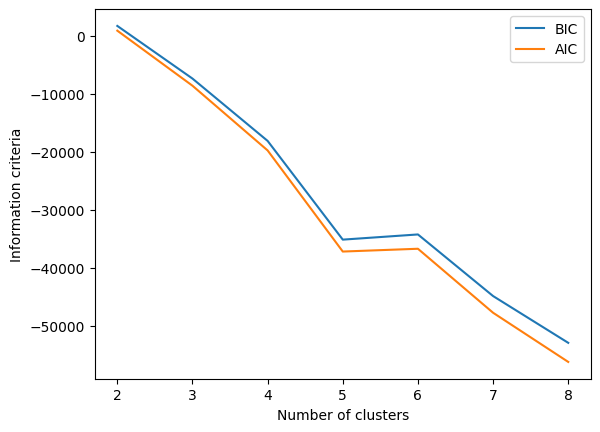

In [7]:

bic_scores = []
aic_scores = []
for k in n_clusters:
    gmm = GaussianMixture(n_components=k, covariance_type='full', n_init=10, random_state=1234)
    gmm.fit(MD_scaled)
    bic_scores.append(gmm.bic(MD_scaled))
    aic_scores.append(gmm.aic(MD_scaled))

plt.plot(n_clusters, bic_scores, label='BIC')
plt.plot(n_clusters, aic_scores, label='AIC')
plt.xlabel("Number of clusters")
plt.ylabel("Information criteria")
plt.legend()
plt.show()

In [8]:

gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, random_state=1234)
gmm.fit(MD_scaled)
data['gmm_cluster'] = gmm.predict(MD_scaled)


kmeans_labels = kmeans_models[2].labels_
gmm_labels = data['gmm_cluster']

comparison_table = pd.crosstab(kmeans_labels, gmm_labels)
print(comparison_table)


gmm_cluster    0    1    2    3
row_0                          
0            235   11  126   26
1            463   13    2  133
2             18    7  272   28
3              0  119    0    0


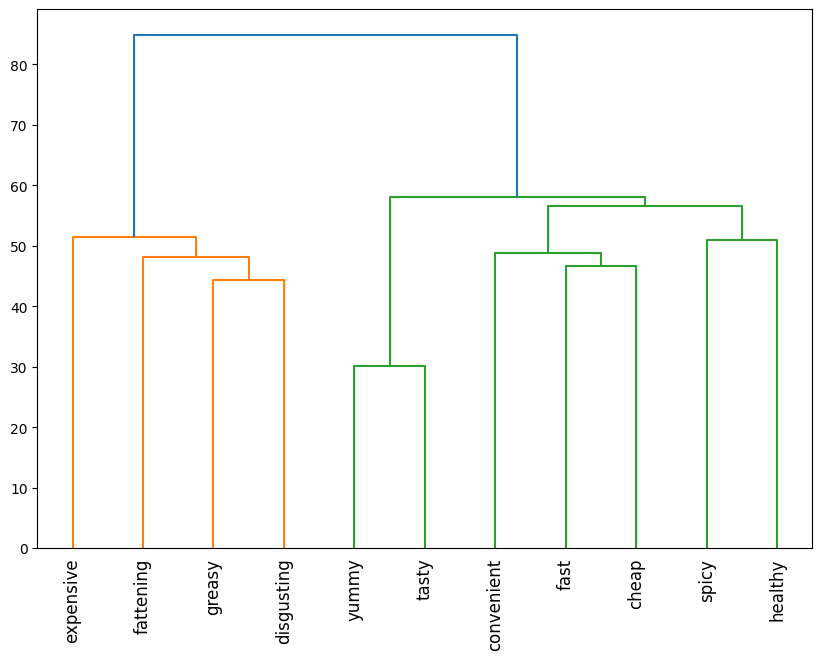

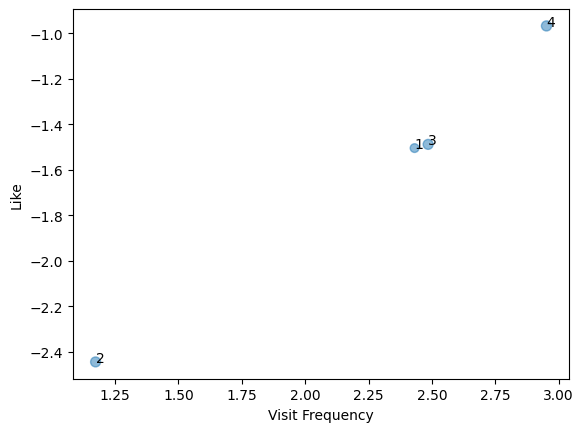

In [9]:

linked = linkage(MD_scaled.T, 'ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, labels=MD.columns.tolist(), leaf_rotation=90)
plt.show()

like_mapping = {
    'I HATE IT!-5': -5,
    '-4': -4,
    '-3': -3,
    '-2': -2,
    '-1': -1,
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    'I LOVE IT!+5': 5
}
data['Like.n'] = data['Like'].map(like_mapping)

visit_mapping = {
    'Never': 0,
    'Once a year': 1,
    'Every three months': 2,
    'Once a month': 3,
    'Once a week': 4,
    'More than once a week': 5
}
data['VisitFrequency.n'] = data['VisitFrequency'].map(visit_mapping)


data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

visit = data.groupby('gmm_cluster')['VisitFrequency.n'].mean()
like = data.groupby('gmm_cluster')['Like.n'].mean()
female = data.groupby('gmm_cluster')['Gender'].mean()

plt.scatter(visit, like, s=female * 100, alpha=0.5)
for i, txt in enumerate(range(1, 5)):
    plt.annotate(txt, (visit[i], like[i]))
plt.xlabel("Visit Frequency")
plt.ylabel("Like")
plt.show()

<Figure size 1000x600 with 0 Axes>

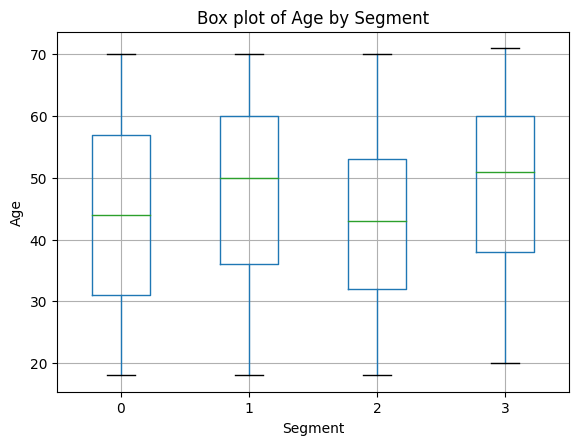

In [10]:
plt.figure(figsize=(10, 6))
data['Age'] = pd.to_numeric(data['Age'], errors='coerce')
data.dropna(subset=['Age'], inplace=True)
data.boxplot(column='Age', by='gmm_cluster')
plt.title('Box plot of Age by Segment')
plt.suptitle('')
plt.xlabel('Segment')
plt.ylabel('Age')
plt.show()

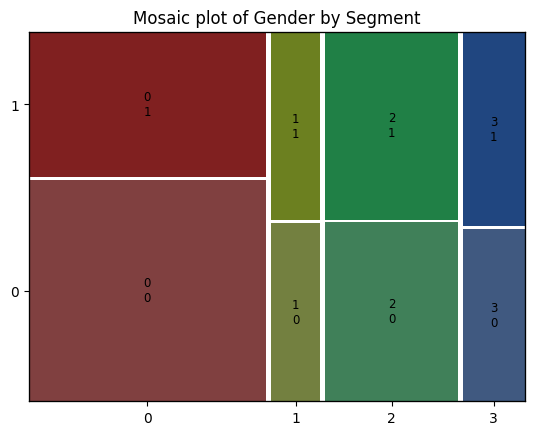

In [11]:
ct = pd.crosstab(data['gmm_cluster'], data['Gender'])
mosaic(ct.stack(), gap=0.01)
plt.title('Mosaic plot of Gender by Segment')
plt.show()

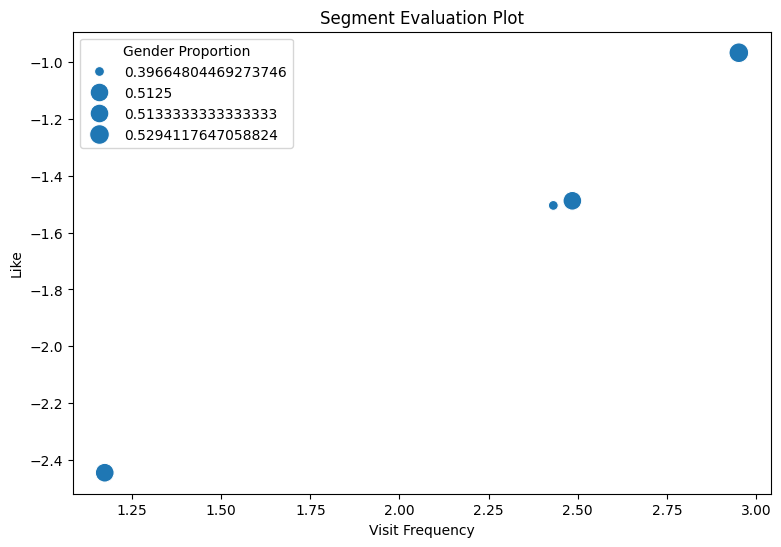

In [12]:
segment = pd.DataFrame({
    'VisitFrequency': visit,
    'Like': like,
    'Gender': female
}).reset_index()

plt.figure(figsize=(9, 6))
sns.scatterplot(x='VisitFrequency', y='Like', data=segment, size='Gender', sizes=(50, 200))
plt.title("Segment Evaluation Plot")
plt.xlabel("Visit Frequency")
plt.ylabel("Like")
plt.legend(title='Gender Proportion')
plt.show()